# System Init

In [1]:
from fov import FOV
from queue import Queue
import numpy as np
from matplotlib import pyplot as plt
#from napari import Viewer
import numpy as np
from queue import Queue
from pymmcore_plus import CMMCorePlus
from useq import MDAEvent
from useq._channel import Channel
import pandas as pd
import random
from utils import ImgType, MetadataDict
#from stimulation import StimExtraParameters
from hardware import load_config
import os
import napari

from napari_micromanager import MainWindow
# from napari_micromanager._core_link import CoreViewerLink


import skimage
import useq
from dmd import DMD

# from tracking import TrackerTrackpy
# from controller import Controller, Analyzer

from utils import create_folders
import numpy as np
import pymmcore_plus

import time

from useq._mda_event import SLMImage
import useq
import requests

mmc = pymmcore_plus.CMMCorePlus()
mmc.loadSystemConfiguration("E:\\MicroManagerConfigs\\Ti2CicercoConfig_w_DMD_11_w_ttl.cfg")

def wakeup_laser(lumencore_ip="192.168.201.200"):
    url = f"http://{lumencore_ip}/service/?command=WAKEUP"
    requests.get(url)
wakeup_laser()

### DMD Full On

In [2]:
# %%capture
slm_dev = mmc.getSLMDevice()
slm_width = mmc.getSLMWidth(slm_dev)
slm_height = mmc.getSLMHeight(slm_dev)

event_slm_on = MDAEvent(slm_image=SLMImage(data=True))
mmc.mda.run([event_slm_on])# to only have fov of DMD 
mmc.setROI(150, 150, 1900, 1900)

DMD_CHANNEL_GROUP = "CF_DMD"
DMD_CALIBRATION_CHANNEL = "CyanStim"
mmc.setChannelGroup(channelGroup=DMD_CHANNEL_GROUP)
# mmc.setProperty("LedDMD", "Cyan_Level", 10)

2025-01-14 12:23:24,102 - pymmcore-plus - INFO - (_runner.py:329) MDA Started: GeneratorMDASequence()
2025-01-14 12:23:24,104 - pymmcore-plus - INFO - (_runner.py:290) slm_image=SLMImage(data=True)
2025-01-14 12:23:24,285 - pymmcore-plus - INFO - (_runner.py:416) MDA Finished: GeneratorMDASequence()


### Napari Micromanger User Interface

In [3]:
viewer = napari.Viewer()
mm_wdg = MainWindow(viewer)
viewer.window.add_dock_widget(mm_wdg)

In [ ]:
mm_wdg._core_link.cleanup()
mm_wdg._core_link = CoreViewerLink(viewer, mmc)

## create a DF with all planned acquisitions and stimulations

In [12]:
df_acquire = pd.DataFrame(columns=['fov', 'timestep', 'time','time_experiment', 'treatment', 'acquired','stim', 'channels', 'channel_stim'])

path = "C:\\test\\"
create_folders(path,['stim','raw','labels','stim_mask','tracks','labels_rings','particles'])

time_between_frames = 10 #time in seconds between frames
stim_timesteps = []  # list of timesteps

timesteps = range(3)  # 0-20
channels = ['Red', 'Green']
channels_exposure = [200, 250]
channels_power = [30, 35]
channel_stim = ['CyanStim']
channel_stim_exposures = [100]
channel_stim_power = [10]
treatment = {'stim_property': 'global'}

for channel, power in zip(channels, channels_power):
    mmc.setProperty("Laser", f"{channel.upper()}_Intensity", power)
for channel, power in zip(channel_stim, channel_stim_power):
    mmc.setProperty("LedDMD", f"{channel.removesuffix('Stim')}_Level", power)

Directory C:\test\stim already exists
Directory C:\test\raw already exists
Directory C:\test\labels already exists
Directory C:\test\stim_mask already exists
Directory C:\test\tracks already exists
Directory C:\test\labels_rings already exists
Directory C:\test\particles already exists


In [17]:
viewer = napari.Viewer()
viewer.window.add_plugin_dock_widget("napari-micromanager")

(<napari._qt.widgets.qt_viewer_dock_widget.QtViewerDockWidget at 0x189b04c2dd0>,
 <napari_micromanager.main_window.MainWindow at 0x189ad04f0a0>)

In [ ]:

# fovs:list[FOV] = []

# data_mda_fovs = data_mda.value()

# for i, row in enumerate(data_mda_fovs.stage_positions):
#     fov = FOV(pos=(row.x, row.y),
#               index=i,
#               name=row.name,
#               path=path,
#               metadata={},
#               treatment={'stim_property': 'global'},
#               )
#     fovs.append(fov)



In [9]:
fovs:list[FOV] = []
fovs.append(FOV(pos=mmc.getXYPosition(), index=0, name="test", path=path, metadata={}, treatment={'stim_property': 'global'}))

In [13]:
dfs = []
for fov in fovs:
    # well_column = int(fov.name.split('_')[0][1:])
    # well_row = fov.name.split('_')[0][0]
    well_column = 1
    well_row = 'A'
    cell_lines = ["optoFGFR1", "optoERK1", "optoERK2", "optoTrkA1"]
    cell_line = cell_lines[well_column]
    for timestep in timesteps:
        new_row = { 'fov_object': fov,
                    'fov':fov.index,
                    'name':fov.name,
                    'well_row': well_row,
                    'well_column': int(well_column),
                    'cell_line': cell_line,
                    'timestep': timestep,
                    'time': timestep*time_between_frames,
                    'treatment': fov.treatment,
                    'acquired': False,
                    'stim': timestep in stim_timesteps,
                    'channels': channels,
                    'channels_exposure':channels_exposure,
                    'channel_power': channels_power,
                    'channel_stim' : channel_stim,
                    'channel_stim_exposure' : channel_stim_exposures,
                    'channel_stim_power' : channel_stim_power,
                    'fname' : f'{str(fov.index).zfill(3)}_{str(timestep).zfill(5)}',
                    }
        dfs.append(new_row)

df_acquire = pd.DataFrame(dfs)
df_acquire = df_acquire.sort_values(by=['timestep', 'fov'])

df_acquire


,fov_object,fov,name,well_row,well_column,cell_line,timestep,time,treatment,acquired,stim,channels,channels_exposure,channel_power,channel_stim,channel_stim_exposure,channel_stim_power,fname
0,<fov.FOV object at 0x000001C2558AAC10>,0,test,A,1,optoERK1,0,0,{'stim_property': 'global'},False,False,"[Red, Green]","[200, 250]","[30, 35]",[CyanStim],[100],[10],000_00000
1,<fov.FOV object at 0x000001C2558AAC10>,0,test,A,1,optoERK1,1,10,{'stim_property': 'global'},False,False,"[Red, Green]","[200, 250]","[30, 35]",[CyanStim],[100],[10],000_00001
2,<fov.FOV object at 0x000001C2558AAC10>,0,test,A,1,optoERK1,2,20,{'stim_property': 'global'},False,False,"[Red, Green]","[200, 250]","[30, 35]",[CyanStim],[100],[10],000_00002


## Run on system with DMD

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2025-01-14 11:41:08,857 - pymmcore-plus - INFO - (_runner.py:329) MDA Started: GeneratorMDASequence()
2025-01-14 11:41:08,859 - pymmcore-plus - INFO - (_runner.py:290) channel=Channel(config='CyanStim', group='CF_DMD') exposure=100.0 slm_image=SLMImage(data=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), device='MightexPolygon1000') events=(MDAEvent(channel=Channel(config='CyanStim', group='CF_DMD'), exposure=100.0, slm_image=SLMImage(data=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), device='MightexPolygon1000')), MDAEvent(channel=Channel(config='CyanStim', group='CF_DMD'), exposure=100.0, slm_image=SLMImage(data=array([[0, 0, 0, ..., 0, 0, 0],
  

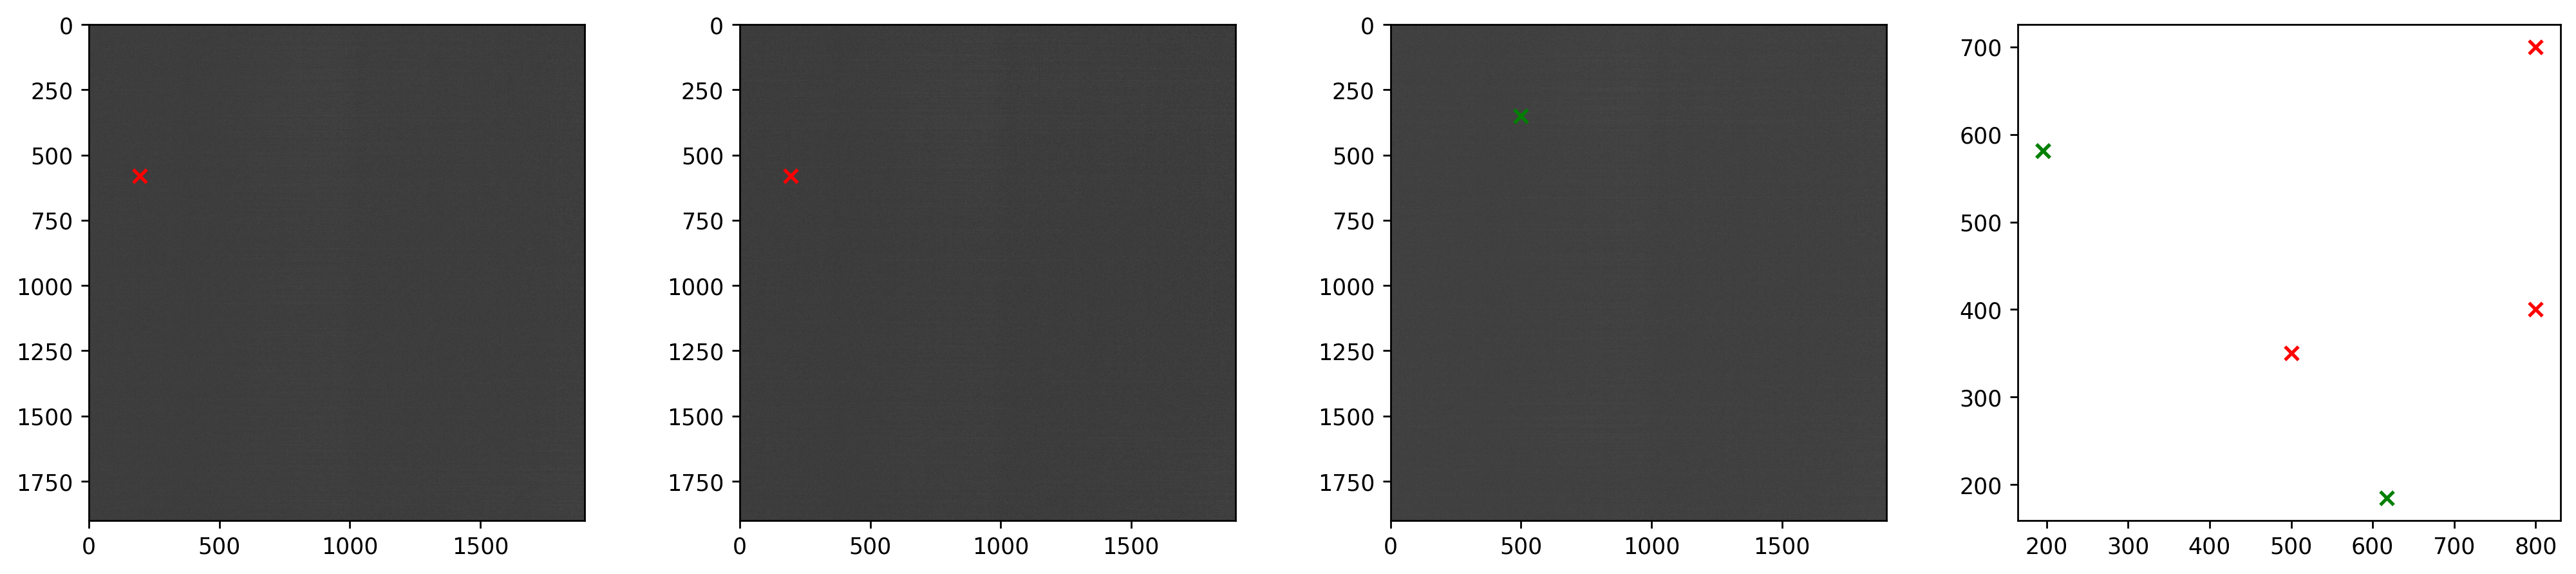

In [10]:
%load_ext autoreload
%autoreload 2

dmd = DMD(mmc, DMD_CHANNEL_GROUP, DMD_CALIBRATION_CHANNEL)
dmd.calibrate(verbous=True)

2025-01-14 12:26:37,939 - pymmcore-plus - INFO - (_runner.py:329) MDA Started: GeneratorMDASequence()
2025-01-14 12:26:37,942 - pymmcore-plus - INFO - (_runner.py:290) index={'t': 0} channel=Channel(config='Red', group='CF_DMD') exposure=200.0 min_start_time=0.0 x_pos=-4547.3 y_pos=8269.800000000001 metadata={'fov_object': <fov.FOV object at 0x000001C2558AAC10>, 'fov': 0, 'name': 'test', 'well_row': 'A', 'well_column': 1, 'cell_line': 'optoERK1', 'timestep': 0, 'time': 0, 'treatment': {'stim_property': 'global'}, 'acquired': False, 'stim': False, 'channels': ['Red', 'Green'], 'channels_exposure': [200, 250], 'channel_power': [30, 35], 'channel_stim': ['CyanStim'], 'channel_stim_exposure': [100], 'channel_stim_power': [10], 'fname': '000_00000', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': False, 'channel': 'Red'}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


2025-01-14 12:26:38,273 - pymmcore-plus - INFO - (_runner.py:290) index={'t': 0} channel=Channel(config='Green', group='CF_DMD') exposure=250.0 min_start_time=0.0 x_pos=-4547.3 y_pos=8269.800000000001 metadata={'fov_object': <fov.FOV object at 0x000001C2558AAC10>, 'fov': 0, 'name': 'test', 'well_row': 'A', 'well_column': 1, 'cell_line': 'optoERK1', 'timestep': 0, 'time': 0, 'treatment': {'stim_property': 'global'}, 'acquired': False, 'stim': False, 'channels': ['Red', 'Green'], 'channels_exposure': [200, 250], 'channel_power': [30, 35], 'channel_stim': ['CyanStim'], 'channel_stim_exposure': [100], 'channel_stim_power': [10], 'fname': '000_00000', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True, 'channel': 'Green'}


Store raw image
Segmenting image


functional.py (237): The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(1, 1904, 1904, 1))


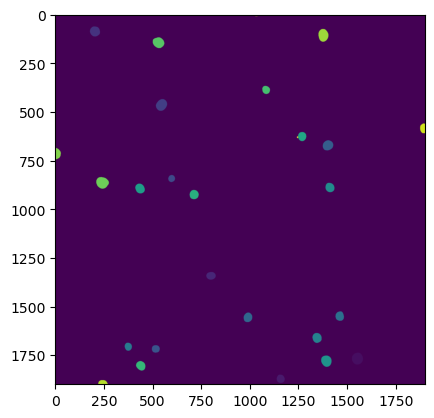

Store raw image
Segmenting image


functional.py (237): The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(1, 1904, 1904, 1))


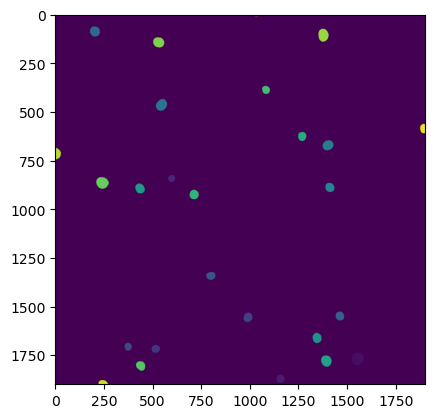

2025-01-14 12:26:47,943 - pymmcore-plus - INFO - (_runner.py:290) index={'t': 1} channel=Channel(config='Red', group='CF_DMD') exposure=200.0 min_start_time=10.0 x_pos=-4547.3 y_pos=8269.800000000001 metadata={'fov_object': <fov.FOV object at 0x000001C2558AAC10>, 'fov': 0, 'name': 'test', 'well_row': 'A', 'well_column': 1, 'cell_line': 'optoERK1', 'timestep': 1, 'time': 10, 'treatment': {'stim_property': 'global'}, 'acquired': False, 'stim': False, 'channels': ['Red', 'Green'], 'channels_exposure': [200, 250], 'channel_power': [30, 35], 'channel_stim': ['CyanStim'], 'channel_stim_exposure': [100], 'channel_stim_power': [10], 'fname': '000_00001', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': False, 'channel': 'Red'}
2025-01-14 12:26:48,272 - pymmcore-plus - INFO - (_runner.py:290) index={'t': 1} channel=Channel(config='Green', group='CF_DMD') exposure=250.0 min_start_time=10.0 x_pos=-4547.3 y_pos=8269.800000000001 metadata={'fov_object': <fov.FOV object at 0x000001C2558AAC10>, 'fov

Store raw image
Segmenting image


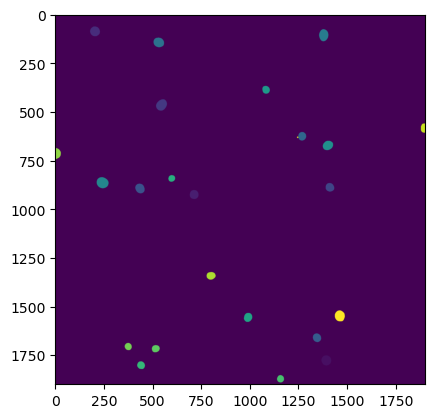

Store raw image
Segmenting image


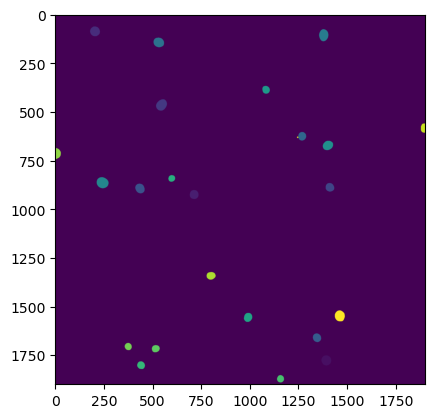

2025-01-14 12:26:57,943 - pymmcore-plus - INFO - (_runner.py:290) index={'t': 2} channel=Channel(config='Red', group='CF_DMD') exposure=200.0 min_start_time=20.0 x_pos=-4547.3 y_pos=8269.800000000001 metadata={'fov_object': <fov.FOV object at 0x000001C2558AAC10>, 'fov': 0, 'name': 'test', 'well_row': 'A', 'well_column': 1, 'cell_line': 'optoERK1', 'timestep': 2, 'time': 20, 'treatment': {'stim_property': 'global'}, 'acquired': False, 'stim': False, 'channels': ['Red', 'Green'], 'channels_exposure': [200, 250], 'channel_power': [30, 35], 'channel_stim': ['CyanStim'], 'channel_stim_exposure': [100], 'channel_stim_power': [10], 'fname': '000_00002', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': False, 'channel': 'Red'}
2025-01-14 12:26:58,251 - pymmcore-plus - INFO - (_runner.py:290) index={'t': 2} channel=Channel(config='Green', group='CF_DMD') exposure=250.0 min_start_time=20.0 x_pos=-4547.3 y_pos=8269.800000000001 metadata={'fov_object': <fov.FOV object at 0x000001C2558AAC10>, 'fov

Store raw image
Segmenting image


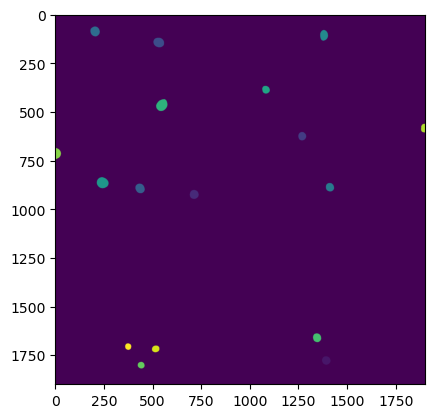

Store raw image
Segmenting image


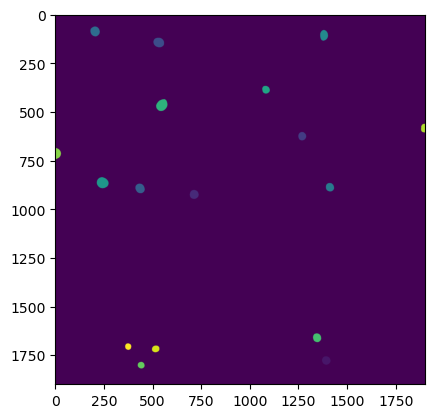

2025-01-14 12:27:02,139 - pymmcore-plus - INFO - (_runner.py:416) MDA Finished: GeneratorMDASequence()


In [14]:
%load_ext autoreload
%autoreload 2

from add_frame import ImageProcessingPipeline
from segmentation_stardist import SegmentatorStardist
from stimulation import StimWholeFOV    
from controller import Controller, Analyzer
from tracking_trackpy import TrackerTrackpy

segmentator = SegmentatorStardist()
stimulator = StimWholeFOV()
tracker = TrackerTrackpy()

pipeline = ImageProcessingPipeline(segmentator,stimulator,tracker)
analyzer = Analyzer(pipeline)
queue = Queue()
controller = Controller(analyzer, mmc, queue)
controller.run(df_acquire)




In [ ]:
mmc.unloadAllDevices()

In [ ]:
from add_frame import ImageProcessingPipeline
from segmentation import SegmentatorStardist
from pymmcore_plus.mda import MDAEngine
from stimulation import StimExtraParameters, StimCircle
from controller import Analyzer

segmentator = SegmentatorStardist('2D_versatile_fluo')
stimulator = StimExtraParameters()
stimulator = StimCircle()
tracker = TrackerTrackpy()
pipeline = ImageProcessingPipeline(segmentator,stimulator,tracker)
analyzer = Analyzer(pipeline)


Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [ ]:
import napari
import zarr
import glob
from skimage.io import imread
from glob import glob
import dask.array as da
from dask import delayed
import os
import numpy as np
from magicgui import magicgui
import pandas as pd



def tiff_to_lazy_da(path,folder,fov, zfill = 2):
    '''Read in all tiff files form the same FOV in a folder and load them lazily with dask. '''
    file_name_pattern = str(fov).zfill(zfill)+"_*.tiff"
    filenames = sorted(glob(path + os.path.join(str(folder),file_name_pattern)))
    # read the first file to get the shape and dtype
    # ASSUMES THAT ALL FILES SHARE THE SAME SHAPE and TYPE

    sample = imread(filenames[0])
    
    lazy_imread = delayed(imread)  # lazy reader
    lazy_arrays = [lazy_imread(fn) for fn in filenames]
    dask_arrays = [
        da.from_delayed(delayed_reader, shape=sample.shape, dtype=sample.dtype)
        for delayed_reader in lazy_arrays
    ]
    # Stack into one large dask.array
    stack = da.stack(dask_arrays, axis=0)
    stack = np.squeeze(stack)
    return stack

project_path = '\\\\izbkingston.unibe.ch\\imaging.data\\lhinder\\data\\rtm_mm_data\\exp_352\\'
stack_raw = tiff_to_lazy_da(project_path, "raw", 0,zfill=2)
stack_stim = tiff_to_lazy_da(project_path, "stim", 0,zfill=2)

In [ ]:
df_acquire

,fov_object,fov,name,well_row,well_column,cell_line,timestep,time,treatment,acquired,stim,channels,channels_exposure,channel_power,channel_stim,channel_stim_exposure,channel_stim_power,fname
0,<fov.FOV object at 0x000001C8F3166910>,0,test,A,1,optoERK1,0,0,{'stim_property': 'global'},False,False,[CyanStim],[200],[2],[CyanStim],[500],[2],000_00000
1,<fov.FOV object at 0x000001C8F3166910>,0,test,A,1,optoERK1,1,5,{'stim_property': 'global'},False,True,[CyanStim],[200],[2],[CyanStim],[500],[2],000_00001
2,<fov.FOV object at 0x000001C8F3166910>,0,test,A,1,optoERK1,2,10,{'stim_property': 'global'},False,False,[CyanStim],[200],[2],[CyanStim],[500],[2],000_00002


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
Segmenting image


functional.py (237): The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(1, 1024, 1024, 1))


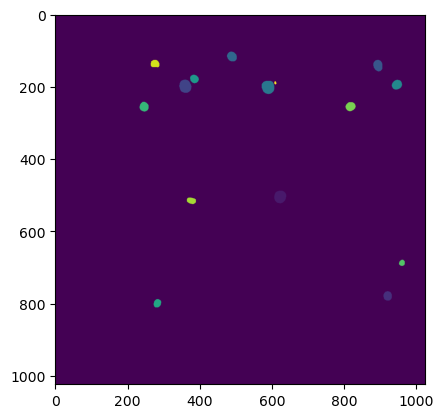

Segmenting image


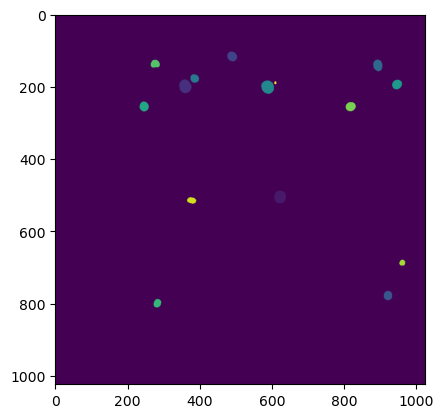

Segmenting image


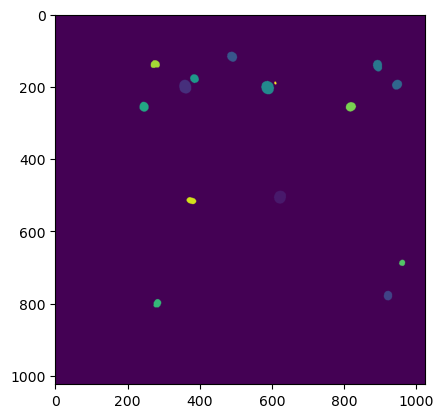

In [ ]:

%load_ext autoreload
%autoreload 2

from controller_simulation import Controller, Analyzer
from dmd import DMD



from add_frame import ImageProcessingPipeline
from segmentation_stardist import SegmentatorStardist
from stimulation import StimWholeFOV    
from tracking_trackpy import TrackerTrackpy

segmentator = SegmentatorStardist()
stimulator = StimWholeFOV()
tracker = TrackerTrackpy()

pipeline = ImageProcessingPipeline(segmentator,stimulator,tracker)
analyzer = Analyzer(pipeline)



dmd = DMD(mmc, test_mode = True)
# mda_engine_dmd = MDAEngine_DMD(dmd)

# mmc.mda.set_engine(mda_engine_dmd)

queue = Queue()

### RUN THIS IF YOU WANT TO TEST THE ACQUISITION WITHOUT ACTUAL HARDWARE
analyzer = Analyzer(pipeline)
controller = Controller(analyzer, mmc, queue,stack_raw=stack_raw,stack_stim=stack_stim)


# Start the acquisition
controller.run(df_acquire)


In [ ]:
df = pd.read_parquet("C:\\test\\tracks\\000_00001.parquet")

In [ ]:
df.head(1)

,mean_intensity_C0_nuc,label,x,y,mean_intensity_C0_ring,particle,frame,stim,time,fov,...,treatment,acquired,channels,channels_exposure,channel_power,channel_stim,channel_stim_exposure,channel_stim_power,fname,last_channel
0,247.140086,1,505.483836,622.758621,189.115582,0,0,True,5,0.0,...,None,False,[CyanStim],[200],[2],[CyanStim],[500],[2],000_00001,True


In [ ]:
df.dtypes

mean_intensity_C0_nuc     float64
label                       int32
x                         float64
y                         float64
mean_intensity_C0_ring    float64
particle                    int64
frame                       int64
stim                         bool
time                        int64
fov                       float64
name                       object
well_row                   object
well_column               float64
cell_line                  object
timestep                  float64
treatment                  object
acquired                     bool
channels                   object
channels_exposure          object
channel_power              object
channel_stim               object
channel_stim_exposure      object
channel_stim_power         object
fname                      object
last_channel                 bool
dtype: object

In [ ]:
def normalize_mi_ma(x, mi, ma, clip=False, eps=1e-20, dtype=np.float32):
    if dtype is not None:
        x   = x.astype(dtype,copy=False)
        mi  = dtype(mi) if np.isscalar(mi) else mi.astype(dtype,copy=False)
        ma  = dtype(ma) if np.isscalar(ma) else ma.astype(dtype,copy=False)
        eps = dtype(eps)

def normalize(x, pmin=3, pmax=99.8, axis=None, clip=False, eps=1e-20, dtype=np.float32):
    """Percentile-based image normalization."""

    mi = np.percentile(x.flatten(),pmin)
    ma = np.percentile(x.flatten(),pmax)
    return normalize_mi_ma(x, mi, ma, clip=clip, eps=eps, dtype=dtype)

normalize(np.ones((1000,1000)))
print(np.ones((1000,1000)).flatten().shape)

(1000000,)
